<a href="https://colab.research.google.com/github/kumbhars/Modelling-and-optimization/blob/main/modellingandoptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install tweet-preprocessor
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import preprocessor
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
from nltk import word_tokenize, FreqDist, bigrams, trigrams
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import spacy
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder
import gensim
from gensim import corpora
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import json
import networkx as nx
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import gensim.downloader as api
from gensim.models import CoherenceModel
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
stop_word_list = stopwords.words('english')

In [13]:
import plotly.io as pio
pio.renderers.default = "colab"

In [14]:
reviews=pd.read_csv('IMDB Dataset.csv')
print(reviews.head())
reviews.shape

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


(50000, 2)

In [15]:
reviews.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [16]:
# dropping ALL duplicte values
new_reviews_df=reviews.drop_duplicates()
print(new_reviews_df.head())
print(new_reviews_df.shape)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(49582, 2)


In [17]:
def pre_process(comms):
    comms = comms.lower()
    comms = re.sub("https?:\/\/\S+", "", comms)
    comms = re.sub("<br />", "", comms)
    comms = re.sub(r'\d+', '', str(comms))
    translator = str.maketrans('', '', string.punctuation)
    comms = comms.translate(translator)

    comms = word_tokenize(comms)

    stop_words = set(stopwords.words('english'))
    comms = [i for i in comms if not i in stop_words]

    lemmatizer = WordNetLemmatizer()
    comms = [lemmatizer.lemmatize(token) for token in comms]

    comms = ' '.join(comms)
    return comms


In [18]:
filtered_reviews = []
for index, row in new_reviews_df.iterrows():
    parsed_review = preprocessor.clean(str(row['review']))
    pp_review = pre_process(parsed_review)
    filtered_reviews.append(pp_review)

new_reviews_df['filtered_reviews'] = filtered_reviews
new_reviews_df.head()

<ipython-input-18-e1d767dd1b16>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review,sentiment,filtered_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [19]:
tokens = []
for comms in new_reviews_df["filtered_reviews"]:
    for token in word_tokenize(comms):
        tokens.append(token)

In [20]:
print(tokens[:25])

['one', 'reviewer', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly', 'happened', 'methe', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust']


In [21]:
freq_counts = Counter(tokens)
top_tokens = freq_counts.most_common(25)
token, token_counts = zip(*top_tokens)

In [22]:
fig = px.bar(x=list(token), y=list(token_counts), labels={'x': 'Tokens', 'y': 'Count'}, text=list(token_counts))
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(title='Most Common Tokens', xaxis_tickangle=-45)
fig.show()

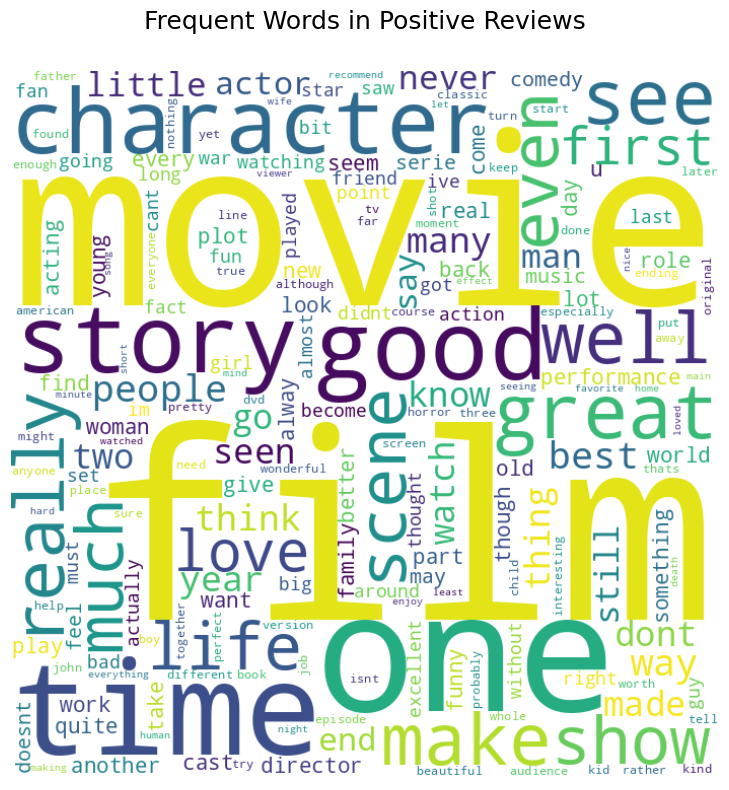

In [23]:

pos_reviews_df = new_reviews_df[new_reviews_df['sentiment'] == 'positive']
pos_reviews = ' '.join(str(review) for review in pos_reviews_df['filtered_reviews'])

pos_reviews_cloud = WordCloud(width=700, height=700,colormap='viridis',background_color='white',min_font_size=10,collocations=False).generate(pos_reviews)

fig, ax = plt.subplots(figsize=(8, 8), facecolor=None)
plt.imshow(pos_reviews_cloud, interpolation='bilinear')
plt.axis("off")
ax.set_title("Frequent Words in Positive Reviews", fontsize=18, pad=30)
plt.tight_layout()
plt.show()

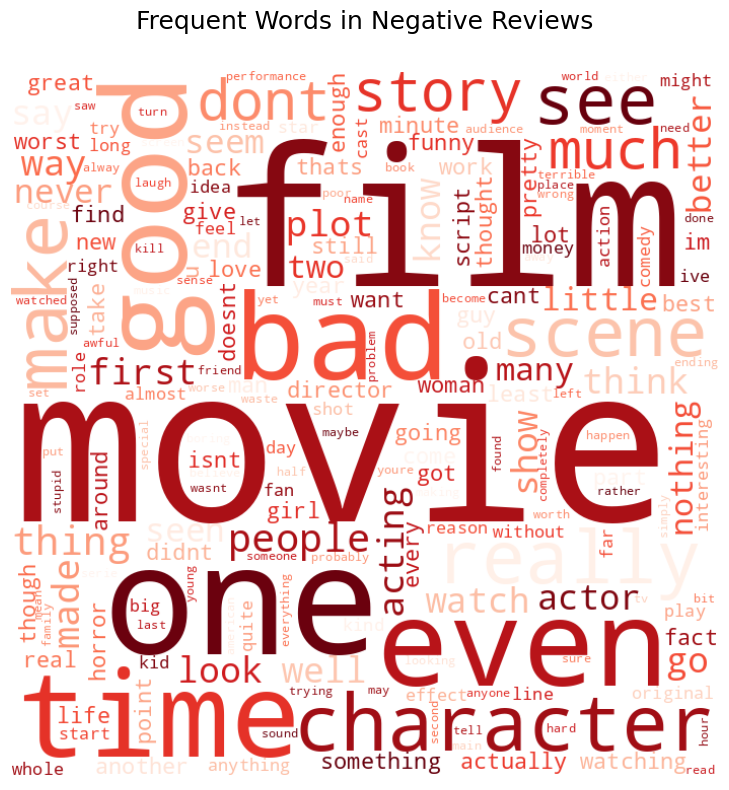

In [24]:
neg_reviews_df = new_reviews_df[new_reviews_df['sentiment'] == 'negative']
neg_reviews = ' '.join(str(review) for review in neg_reviews_df['filtered_reviews'])

neg_reviews_cloud = WordCloud(width=700, height=700,colormap='Reds',background_color='white',min_font_size=10,collocations=False).generate(neg_reviews)

fig, ax = plt.subplots(figsize=(8, 8), facecolor=None)
plt.imshow(neg_reviews_cloud, interpolation='bilinear')
plt.axis("off")
ax.set_title("Frequent Words in Negative Reviews", fontsize=18, pad=30)
plt.tight_layout()
plt.show()

In [25]:
reviewList = []
for reviews in new_reviews_df["filtered_reviews"]:
    tokens = []
    for token in word_tokenize(reviews):
        tokens.append(token)
    reviewList.append(tokens)

In [26]:
bi_list = []
for review_tokens in reviewList:
    bi_list.extend(list(bigrams(review_tokens)))
bi_grams_common = Counter(bi_list)
bi_grams_common.most_common(25)

[(('look', 'like'), 2854),
 (('ever', 'seen'), 2521),
 (('special', 'effect'), 2190),
 (('ive', 'seen'), 2127),
 (('dont', 'know'), 2040),
 (('main', 'character'), 1857),
 (('even', 'though'), 1849),
 (('one', 'best'), 1834),
 (('year', 'old'), 1731),
 (('movie', 'like'), 1702),
 (('movie', 'ever'), 1535),
 (('horror', 'movie'), 1485),
 (('see', 'movie'), 1481),
 (('good', 'movie'), 1451),
 (('waste', 'time'), 1424),
 (('much', 'better'), 1412),
 (('horror', 'film'), 1364),
 (('watch', 'movie'), 1348),
 (('first', 'time'), 1321),
 (('im', 'sure'), 1314),
 (('bad', 'movie'), 1310),
 (('ive', 'ever'), 1295),
 (('make', 'movie'), 1273),
 (('new', 'york'), 1271),
 (('film', 'like'), 1245)]

In [27]:
init_notebook_mode(connected=True)

my_graph = nx.Graph()
for bigram, freq in bi_grams_common.most_common(25):
    my_graph.add_edge(bigram[0], bigram[1], weight=freq)

# Get positions of nodes using Fruchterman-Reingold algorithm
pos = nx.spring_layout(my_graph, k=1)

# Create edges trace
edge_trace = go.Scatter(x=[],y=[],line=dict(width=0.5, color='#888'),hoverinfo='none', mode='lines')

# Add edge coordinates to trace
for edge in my_graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# Create nodes trace
node_trace = go.Scatter(x=[], y=[],text=[],mode='markers+text',hoverinfo='text',textfont=dict(size=16, color='black'))

# Add node coordinates and labels to trace
for node in my_graph.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([node])

# Set layout and plot
layout = go.Layout(title='Bigram Network',titlefont=dict(size=16),showlegend=False,hovermode='closest',margin=dict(b=20, l=5, r=5, t=40),xaxis=dict(showgrid=True, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=True, zeroline=False, showticklabels=False))

fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
fig.show(renderer="colab")

In [28]:
tri_list = []
for review_tokens in reviewList:
    tri_list.extend(list(trigrams(review_tokens)))
tri_grams_common = Counter(tri_list)
tri_grams_common.most_common(25)

[(('ive', 'ever', 'seen'), 983),
 (('worst', 'movie', 'ever'), 564),
 (('movie', 'ever', 'seen'), 511),
 (('movie', 'ive', 'ever'), 362),
 (('movie', 'ever', 'made'), 338),
 (('one', 'worst', 'movie'), 324),
 (('dont', 'waste', 'time'), 323),
 (('movie', 'ive', 'seen'), 294),
 (('film', 'ever', 'made'), 291),
 (('worst', 'film', 'ever'), 269),
 (('new', 'york', 'city'), 262),
 (('film', 'ive', 'seen'), 256),
 (('film', 'ever', 'seen'), 248),
 (('dont', 'get', 'wrong'), 238),
 (('worst', 'movie', 'ive'), 233),
 (('world', 'war', 'ii'), 206),
 (('film', 'ive', 'ever'), 191),
 (('one', 'worst', 'film'), 178),
 (('waste', 'time', 'money'), 171),
 (('one', 'best', 'movie'), 170),
 (('based', 'true', 'story'), 163),
 (('one', 'best', 'film'), 160),
 (('seen', 'long', 'time'), 155),
 (('first', 'time', 'saw'), 149),
 (('ive', 'never', 'seen'), 144)]

In [29]:
init_notebook_mode(connected=True)

my_graph = nx.Graph()
for bigram, freq in tri_grams_common.most_common(25):
    my_graph.add_edge(bigram[0], bigram[1], weight=freq)
    my_graph.add_edge(bigram[1], bigram[2], weight=freq)

# Get positions of nodes using Fruchterman-Reingold algorithm
pos = nx.spring_layout(my_graph, k=1)

# Create edges trace
edge_trace = go.Scatter(x=[],y=[],line=dict(width=0.5, color='#888'),hoverinfo='none',mode='lines')

# Add edge coordinates to trace
for edge in my_graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# Create nodes trace
node_trace = go.Scatter(x=[],y=[],text=[],mode='markers+text',hoverinfo='text',textfont=dict(size=16, color='black'))

# Add node coordinates and labels to trace
for node in my_graph.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([node])

# Set layout and plot
layout = go.Layout(title='Trigram Network',titlefont=dict(size=16),showlegend=False,hovermode='closest',margin=dict(b=20, l=5, r=5, t=40),
    xaxis=dict(showgrid=True, zeroline=False, showticklabels=False),yaxis=dict(showgrid=True, zeroline=False, showticklabels=False))

fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
#iplot(fig)
fig.show(renderer="colab")


In [30]:
bigram_measures = BigramAssocMeasures()
trigram_measures = TrigramAssocMeasures()

stop_words = set(stopwords.words('english'))
new_reviews = new_reviews_df['filtered_reviews']

def get_ngrams(n, reviews):
    tokens = [word_tokenize(review) for review in reviews]
    if n == 2:
        finder = BigramCollocationFinder.from_documents(tokens)
        measures = bigram_measures
    elif n == 3:
        finder = TrigramCollocationFinder.from_documents(tokens)
        measures = trigram_measures
    else:
        return None
    finder.apply_freq_filter(5)
    scores = finder.score_ngrams(measures.pmi)
    df = pd.DataFrame(scores, columns=[f'{n}gram', 'pmi'])
    df.sort_values(by='pmi', axis=0, ascending=False, inplace=True)
    return df[df.apply(lambda row: filter_ngram(row[f'{n}gram'], n, stop_words) and row.pmi > 5, axis=1)][:500]


def filter_ngram(ngram, n, stop_words):
    if 'PRON' in ngram:
        return False
    if n == 2:
        if ngram[0] in stop_words or ngram[1] in stop_words:
            return False
        tag1, tag2 = nltk.pos_tag(ngram)[0][1], nltk.pos_tag(ngram)[1][1]
        if tag1 not in ['JJ', 'NN'] or tag2 not in ['NN']:
            return False
    elif n == 3:
        if ngram[0] in stop_words or ngram[-1] in stop_words or ngram[1] in stop_words:
            return False
        tag1, tag2, tag3 = nltk.pos_tag(ngram)[0][1], nltk.pos_tag(ngram)[1][1], nltk.pos_tag(ngram)[2][1]
        if tag1 not in ['JJ', 'NN'] or tag2 not in ['JJ','NN'] or tag3 not in ['NN']:
            return False
    return True


In [31]:
bigrams = get_ngrams(2, new_reviews)
trigrams = get_ngrams(3, new_reviews)

In [32]:
# define function to replace ngrams in text
def replace_ngrams(text, ngrams):
    for ngram in ngrams:
        text = text.replace(ngram, ngram.replace(" ", "_"))
    return text

# check column names of bigrams and trigrams dataframes
print(bigrams.columns)
print(trigrams.columns)
new_reviews_df['filtered_reviews'] = new_reviews_df['filtered_reviews'].map(lambda x: replace_ngrams(x, [ ' '.join(ngram) for ngram in bigrams['2gram'].values ]))
new_reviews_df['filtered_reviews'] = new_reviews_df['filtered_reviews'].map(lambda x: replace_ngrams(x, [ ' '.join(ngram) for ngram in trigrams['3gram'].values ]))


Index(['2gram', 'pmi'], dtype='object')
Index(['3gram', 'pmi'], dtype='object')


In [33]:
new_reviews_df.head()

,review,sentiment,filtered_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [34]:
final_reviews = new_reviews_df['filtered_reviews'].map(lambda x: [word for word in x.split() if word not in stop_words and len(word) > 2])
final_reviews = final_reviews.map(lambda x: [word[0] for word in nltk.pos_tag(x) if word[1] in ['NN']])


In [35]:
print(final_reviews.shape)
print(final_reviews.head())

(49582,)
0    [reviewer, episode, youll, thing, brutality, s...
1    [production, technique, fashion, comforting, s...
2    [way, time, summer, weekend, air, theater, com...
3    [family, jake, zombie, closet, parent, movie, ...
4    [petter, time, money, film, watch, mattei, off...
Name: filtered_reviews, dtype: object


In [36]:
new_reviews_df1 = pd.DataFrame(final_reviews.iloc[:49582])
new_reviews_LDA = pd.DataFrame(final_reviews.iloc[:10000])
print(new_reviews_LDA.shape)
print(new_reviews_LDA.head())

(10000, 1)
                                    filtered_reviews
0  [reviewer, episode, youll, thing, brutality, s...
1  [production, technique, fashion, comforting, s...
2  [way, time, summer, weekend, air, theater, com...
3  [family, jake, zombie, closet, parent, movie, ...
4  [petter, time, money, film, watch, mattei, off...


In [37]:
dictionary = corpora.Dictionary(new_reviews_LDA['filtered_reviews'].tolist())
doc_term_matrix = [dictionary.doc2bow(doc) for doc in new_reviews_LDA['filtered_reviews'].tolist()]

In [38]:
stop_words = nltk.corpus.stopwords.words('english')

tf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
vect_matrix = tf_vectorizer.fit_transform(' '.join(review) for review in new_reviews_df1['filtered_reviews'])
print(tf_vectorizer.get_feature_names_out()[:30])


['ability' 'accent' 'accident' 'account' 'act' 'action' 'actor' 'actress'
 'adaptation' 'addition' 'admit' 'adult' 'adventure' 'advice' 'affair'
 'age' 'agent' 'air' 'alan' 'alien' 'america' 'angle' 'animal' 'animation'
 'answer' 'anthony' 'anybody' 'apartment' 'appeal' 'appearance']


<h1> LDA

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


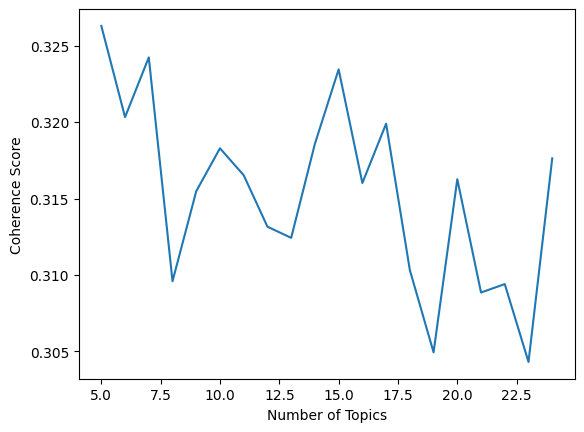

In [39]:
# find optimal number of topics using coherence score
coherence = []
for k in range(5, 25):
    print('Round: '+str(k))
    ldamodel = gensim.models.ldamulticore.LdaMulticore(doc_term_matrix, num_topics=k, id2word=dictionary, passes=15, workers=3)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_lda)

# plot coherence scores against the number of topics
plt.plot(range(5, 25), coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()


In [40]:
# train LDA model with the optimal number of topics
optimal_k = coherence.index(max(coherence)) + 5
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=optimal_k, id2word=dictionary, passes=15)

# print topics and top 10 words for each topic
for idx, topic in ldamodel.show_topics(formatted=False, num_topics=optimal_k, num_words=10):
    print(f'Topic: {idx + 1}')
    print(f'Top 10 words: {[word[0] for word in topic]}')
    print('\n')

Topic: 1
Top 10 words: ['film', 'movie', 'time', 'scene', 'thing', 'character', 'horror', 'plot', 'way', 'story']


Topic: 2
Top 10 words: ['game', 'bond', 'murphy', 'hitler', 'mario', 'connery', 'gadget', 'cat', 'streisand', 'caine']


Topic: 3
Top 10 words: ['film', 'story', 'character', 'life', 'time', 'performance', 'man', 'year', 'role', 'scene']


Topic: 4
Top 10 words: ['movie', 'story', 'character', 'book', 'war', 'time', 'scene', 'world', 'film', 'version']


Topic: 5
Top 10 words: ['movie', 'time', 'show', 'character', 'watch', 'thing', 'story', 'dont', 'way', 'year']




In [41]:
topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [42]:
# Create a dictionary to store the top words for each topic
top_words = {}
lambda_val = 0.6 # Weight parameter for combining probabilities and lift scores

# Loop over each topic
for i in range(1, optimal_k + 1):
    # Extract the topic information for the current topic
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    
    # Calculate the relevance score for each word in the topic
    topic['relevance'] = topic['loglift']*(1-lambda_val) + topic['logprob']*lambda_val
    
    # Sort the words by relevance score and keep only the top words
    top_words['Topic ' + str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:10].values
    
# Convert the dictionary to a DataFrame for display
pd.DataFrame(top_words).T


,0,1,2,3,4,5,6,7,8,9
Topic 1,film,movie,horror,scene,time,thing,plot,effect,guy,way
Topic 2,film,story,performance,life,man,role,character,year,woman,time
Topic 3,movie,show,time,watch,dont,thing,character,something,year,way
Topic 4,book,war,movie,story,character,version,world,space,scene,battle
Topic 5,game,bond,murphy,connery,mario,gadget,hitler,streisand,caine,foxx


In [43]:
lda_topic_model = LatentDirichletAllocation(n_components=10, random_state=0).fit(vect_matrix)
doc_topics = lda_topic_model.transform(vect_matrix)

In [44]:
top_words = 10
for i, topic in enumerate(lda_topic_model.components_):
    print(i, [tf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_words - 1:-1]])

0 ['film', 'movie', 'version', 'story', 'performance', 'character', 'role', 'time', 'book', 'actor']
1 ['film', 'movie', 'role', 'comedy', 'performance', 'time', 'character', 'scene', 'actor', 'music']
2 ['movie', 'film', 'time', 'watch', 'dont', 'thing', 'comedy', 'waste', 'money', 'plot']
3 ['film', 'movie', 'horror', 'episode', 'series', 'story', 'character', 'plot', 'time', 'scene']
4 ['movie', 'film', 'character', 'story', 'book', 'actor', 'time', 'plot', 'scene', 'director']
5 ['movie', 'film', 'family', 'kid', 'time', 'child', 'year', 'story', 'character', 'cartoon']
6 ['film', 'war', 'movie', 'time', 'series', 'world', 'story', 'year', 'character', 'scene']
7 ['film', 'movie', 'game', 'murder', 'story', 'time', 'man', 'character', 'scene', 'wife']
8 ['movie', 'film', 'scene', 'guy', 'thing', 'time', 'monster', 'car', 'way', 'plot']
9 ['film', 'movie', 'life', 'story', 'character', 'time', 'woman', 'way', 'scene', 'man']


In [45]:
doc_topic_index = [doc_topics[i].argmax() for i in range(doc_topics.shape[0])]
doc_topic_index[:5]

[8, 9, 2, 4, 9]

In [46]:
new_reviews_df["topic"] = doc_topic_index   # Use the result to add a new column "topic".
new_reviews_df.head()

,review,sentiment,filtered_reviews,topic
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,8
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,9
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,2
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,4
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,9


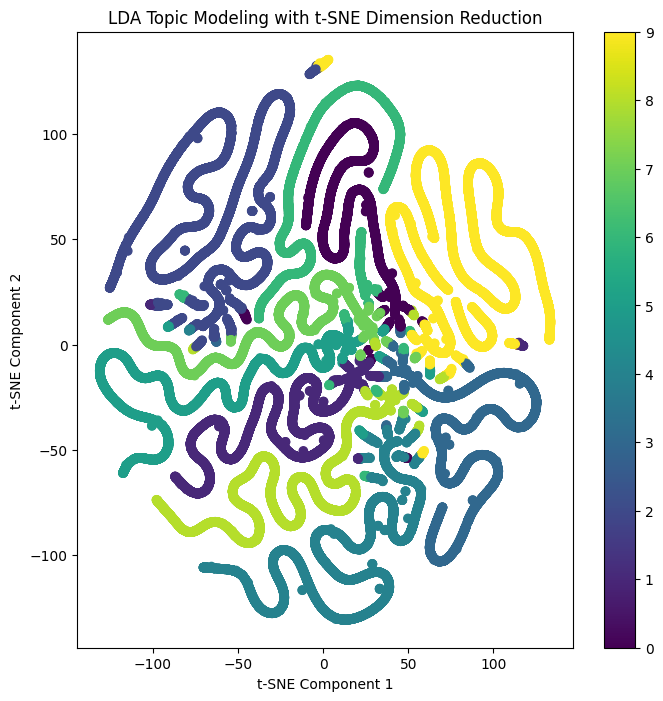

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce the dimensionality of the doc_topics matrix
tsne_model = TSNE(n_components=2, random_state=42, perplexity=50)
tsne_topics = tsne_model.fit_transform(doc_topics)

# Create a scatter plot of the t-SNE results colored by topic
plt.figure(figsize=(8, 8))
plt.scatter(x=tsne_topics[:, 0], y=tsne_topics[:, 1], c=doc_topic_index, cmap='viridis')
plt.title('LDA Topic Modeling with t-SNE Dimension Reduction')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()


<h1>LSA

In [48]:
stop_words=set(nltk.corpus.stopwords.words('english'))

In [49]:
new_reviews_df1.shape

(49582, 1)

In [50]:
# Perform LSA
LSA_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)
LSA_topic_Model = LSA_model.fit_transform(vect_matrix)

# Print the most important words for each topic
imp_words = tf_vectorizer.get_feature_names_out()

In [51]:
# Print the most important words for each topic
imp_words = tf_vectorizer.get_feature_names_out()

for i, component in enumerate(LSA_model.components_):
    vocab_weights = zip(imp_words, component)
    sorted_words = sorted(vocab_weights, key=lambda x: x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for word, weight in sorted_words:
        print(word, end=" ")
    print("\n")



Topic 0: 
movie film time story character scene thing way actor life 

Topic 1: 
movie watch dont waste guy rent kid money wasnt joke 

Topic 2: 
film movie horror budget festival saw review waste rent maker 

Topic 3: 
story book character life performance movie role love actor family 

Topic 4: 
life family man woman year world war wife day child 

Topic 5: 
scene character woman performance man plot guy action sex role 

Topic 6: 
story horror scene effect thing budget gore house blood guy 

Topic 7: 
time actor story performance comedy role waste director script music 

Topic 8: 
book series actor performance role version year play scene star 

Topic 9: 
book time scene version waste adaptation thing character money novel 



In [52]:
doc_topic = LSA_topic_Model / LSA_topic_Model.sum(axis=1, keepdims=True)

# Get topic distribution for each document
LSA_topic_Model_index = [doc_topic[i].argmax() for i in range(doc_topic.shape[0])]
print(LSA_topic_Model_index[:5])

[2, 2, 6, 0, 8]


<ipython-input-52-a52147df6ac0>:1: RuntimeWarning:

invalid value encountered in true_divide



In [53]:
new_reviews_df["topic"] = LSA_topic_Model_index  # Use the result to add a new column "topic".
new_reviews_df.head()

,review,sentiment,filtered_reviews,topic
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,2
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,2
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,6
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,8


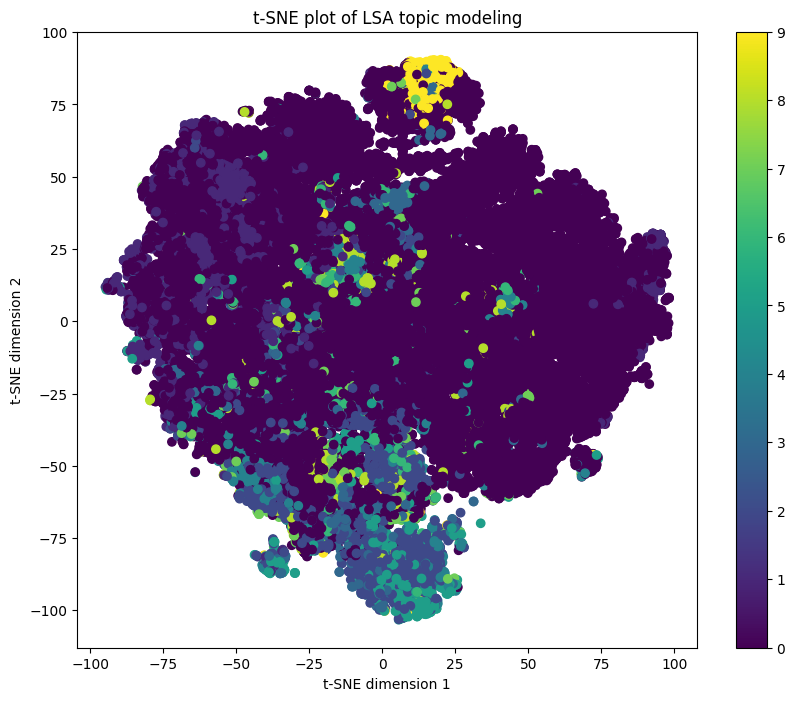

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fit t-SNE to LSA model
tsne_model = TSNE(n_components=2, random_state=42, perplexity=50)
tsne_topics = tsne_model.fit_transform(LSA_topic_Model)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_topics[:, 0], tsne_topics[:, 1], c=LSA_topic_Model_index, cmap='viridis')
plt.title('t-SNE plot of LSA topic modeling')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.colorbar()
plt.show()


In [56]:
# Apply NMF
nmf = NMF(n_components=10, random_state=42)
doc_topics = nmf.fit_transform(vect_matrix)

# Get top 10 words for each topic
all_topics = {}
num_terms = 10
for i, topic in enumerate(nmf.components_):
    all_topics['Topic '+str(i+1)] = [tf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_terms-1:-1]]
    
# Create dataframe of top words for each topic
topics_df = pd.DataFrame(all_topics)

# Get top 10 words for each topic
num_top_words = 10
features = tf_vectorizer.get_feature_names_out()
topic_words = []
for tops in nmf.components_:
    word_idx = tops.argsort()[::-1][0:num_top_words]
    topic_words.append([features[i] for i in word_idx])

# Print top words for each topic
for i, topic in enumerate(topic_words):
    print("Topic {}: {}".format(i+1, ", ".join(topic)))

Topic 1: movie, watch, dont, plot, thing, didnt, fan, lot, theater, review
Topic 2: film, director, cinema, watch, saw, audience, year, fact, work, fan
Topic 3: character, plot, development, way, care, relationship, situation, point, dialogue, end
Topic 4: story, line, love, music, director, end, tale, way, animation, bit
Topic 5: life, man, woman, family, year, world, war, way, wife, child
Topic 6: series, episode, season, fan, television, year, watch, star, dvd, cartoon
Topic 7: scene, horror, guy, plot, action, thing, effect, look, lot, way
Topic 8: time, waste, watch, money, dont, thing, year, hour, minute, day
Topic 9: actor, performance, role, comedy, play, cast, script, director, work, star
Topic 10: book, version, adaptation, novel, jane, read, author, change, production, fact


In [57]:
doc_topic_index = [doc_topics[i].argmax() for i in range(doc_topics.shape[0])]
doc_topic_index[:5]

[6, 8, 8, 4, 7]

In [58]:
new_reviews_df["topic"] = doc_topic_index  # Use the result to add a new column "topic".
new_reviews_df.head()

,review,sentiment,filtered_reviews,topic
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,6
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,8
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,8
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,4
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,7


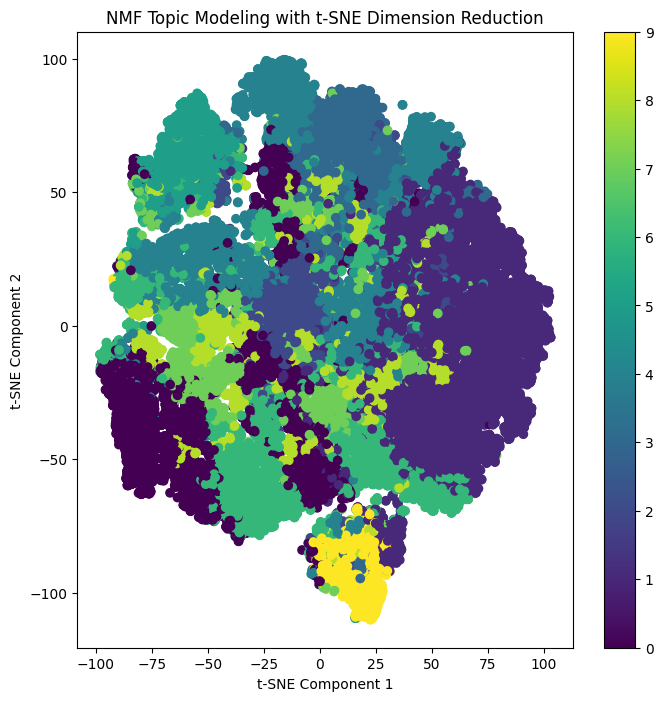

In [59]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce the dimensionality of the doc_topics matrix
tsne_model = TSNE(n_components=2, random_state=42, perplexity=50)
tsne_topics = tsne_model.fit_transform(doc_topics)

# Create a scatter plot of the t-SNE results colored by topic
plt.figure(figsize=(8, 8))
plt.scatter(x=tsne_topics[:, 0], y=tsne_topics[:, 1], c=doc_topic_index, cmap='viridis')
plt.title('NMF Topic Modeling with t-SNE Dimension Reduction')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()
